In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import datetime

In [14]:
df = pd.read_csv('E:/HDD Documents/HDD Documents/School/WGU/d214_capstone/data/Warehouse_and_Retail_Sales.csv')

In [15]:
#Take a look at the data so we know what we're working with
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307663 entries, 0 to 307662
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   YEAR              307663 non-null  int64  
 1   MONTH             307663 non-null  int64  
 2   SUPPLIER          307499 non-null  object 
 3   ITEM CODE         307663 non-null  object 
 4   ITEM DESCRIPTION  307663 non-null  object 
 5   ITEM TYPE         307662 non-null  object 
 6   RETAIL SALES      307660 non-null  float64
 7   RETAIL TRANSFERS  307663 non-null  float64
 8   WAREHOUSE SALES   307663 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 21.1+ MB


In [16]:
#Check missing data
df.isnull().any()

YEAR                False
MONTH               False
SUPPLIER             True
ITEM CODE           False
ITEM DESCRIPTION    False
ITEM TYPE            True
RETAIL SALES         True
RETAIL TRANSFERS    False
WAREHOUSE SALES     False
dtype: bool

In [17]:
#There is date information missing; we must correct this before we can continue
#First, we'll add the date values

#add_dates = [{'year': '2018', 'month' : '3'}, {'year': '2018', 'month' : '4'}, {'year': '2018', 'month' : '5'}, {'year': '2018', 'month' : '6'}, {'year': '2018', 'month' : '7'},
# {'year': '2018', 'month' : '8'}, {'year': '2018', 'month' : '9'}, {'year': '2018', 'month' : '10'}, {'year': '2018', 'month' : '11'}, {'year': '2018', 'month' : '12'},
# {'year': '2020', 'month' : '2'}, {'year': '2020', 'month' : '4'}, {'year': '2020', 'month' : '6'}, {'year': '2020', 'month' : '10'}, {'year': '2020', 'month' : '11'},
# {'year': '2020', 'month' : '9'}, {'year': '2020', 'month' : '5'}, {'year': '2020', 'month' : '8'}, {'year': '2020', 'month' : '12'},  ]

#df = df.append(add_dates, ignore_index = True)

In [18]:
#We're going to use RETAIL_SALES so, we need to fill this data with the mean value for the column
df['RETAIL SALES'].fillna((df['RETAIL SALES'].mean()), inplace = True)

In [19]:
#We're going to use ITEM_TYPE in our exploratory reporting but we don't want to add just any value
#Look at column data to see how many values are missing and if we can replace them manually
df[df['ITEM TYPE'].isna()]

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
107006,2017,10,REPUBLIC NATIONAL DISTRIBUTING CO,347939,FONTANAFREDDA BAROLO SILVER LABEL 750 ML,NaN,0.0,0.0,1.0


In [20]:
#Research tells us that this is a WINE. Let's change it.
df['ITEM TYPE'].fillna('WINE', inplace = True)

In [21]:
#The all-caps is annoying, let's change it and check for any leftover nulls
df = df.rename(columns = {'YEAR':'year', 'MONTH':'month', 'ITEM TYPE':'item_type', 'RETAIL SALES':"retail_sales", 'WAREHOUSE SALES':'warehouse_sales'})
df.isnull().any()

year                False
month               False
SUPPLIER             True
ITEM CODE           False
ITEM DESCRIPTION    False
item_type           False
retail_sales        False
RETAIL TRANSFERS    False
warehouse_sales     False
dtype: bool

In [22]:
df['total_sales'] = df['retail_sales'] + df['warehouse_sales']

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307663 entries, 0 to 307662
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   year              307663 non-null  int64  
 1   month             307663 non-null  int64  
 2   SUPPLIER          307499 non-null  object 
 3   ITEM CODE         307663 non-null  object 
 4   ITEM DESCRIPTION  307663 non-null  object 
 5   item_type         307663 non-null  object 
 6   retail_sales      307663 non-null  float64
 7   RETAIL TRANSFERS  307663 non-null  float64
 8   warehouse_sales   307663 non-null  float64
 9   total_sales       307663 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 23.5+ MB


In [24]:
df

,year,month,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,item_type,retail_sales,RETAIL TRANSFERS,warehouse_sales,total_sales
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0,2.00
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0,4.00
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0,1.00
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0,1.00
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0,0.82
...,...,...,...,...,...,...,...,...,...,...
307658,2020,9,BOSTON BEER CORPORATION,WC,WINE CREDIT,REF,0.00,0.0,-70.0,-70.00
307659,2020,9,MAST-JAEGERMEISTER US INC,31828,JAGERMEISTER LIQUEUR - 1.75L,LIQUOR,16.56,15.0,1.0,17.56
307660,2020,10,PRESTIGE BEVERAGE GROUP OF MD LLC,318272,DELOACH MER - 750ML,WINE,0.00,0.0,1.0,1.00
307661,2020,11,PRESTIGE BEVERAGE GROUP OF MD LLC,318276,BODEGAS BRECA GARN - 750ML,WINE,0.25,0.0,2.0,2.25


In [25]:
#We need a 'day' column for the time series. It's not in the data, so we'll set everything to 1
df['day'] = '1'

In [26]:
#Adding a proper date column for the time series analysis
df['date'] = pd.to_datetime(dict(year = df.year, month = df.month, day = df.day))

In [27]:
#Order the DataFrame by the new Data column
df = df.sort_values(['date'], ascending = True)

In [28]:
#Sanity check
df.head()

,year,month,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,item_type,retail_sales,RETAIL TRANSFERS,warehouse_sales,total_sales,day,date
54813,2017,6,BACCHUS IMPORTERS LTD,429600,PERELADA BLC PESCADOR - 750ML,WINE,0.00,0.0,4.0,4.00,1,2017-06-01
51933,2017,6,REPUBLIC NATIONAL DISTRIBUTING CO,333707,STONESTREET ESTATE A/V CHARD - 750ML,WINE,0.00,0.0,1.0,1.00,1,2017-06-01
51932,2017,6,SOUTHERN GLAZERS WINE AND SPIRITS,333688,CASAMIGOS TEQUILA -ANEJO - 750ML,LIQUOR,9.33,7.0,5.0,14.33,1,2017-06-01
51931,2017,6,THE HESS COLLECTION,333686,GLEN CARLOU GR CLASSIQUE - 750ML,WINE,0.08,1.0,0.0,0.08,1,2017-06-01
51930,2017,6,BACCHUS IMPORTERS LTD,333668,BARR HILL VODKA - 750ML,LIQUOR,1.52,0.0,0.0,1.52,1,2017-06-01


In [29]:
df['total_sales']

54813      4.00
51933      1.00
51932     14.33
51931      0.08
51930      1.52
          ...  
27070      5.00
27050      7.00
307660     1.00
307661     2.25
307662     4.27
Name: total_sales, Length: 307663, dtype: float64

In [31]:
#Create second DataFrame for visualizations
df2 = df[['year', 'item_type', 'total_sales']]

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'WINE'),
  Text(1, 0, 'LIQUOR'),
  Text(2, 0, 'KEGS'),
  Text(3, 0, 'BEER'),
  Text(4, 0, 'NON-ALCOHOL'),
  Text(5, 0, 'DUNNAGE'),
  Text(6, 0, 'STR_SUPPLIES'),
  Text(7, 0, 'REF')])

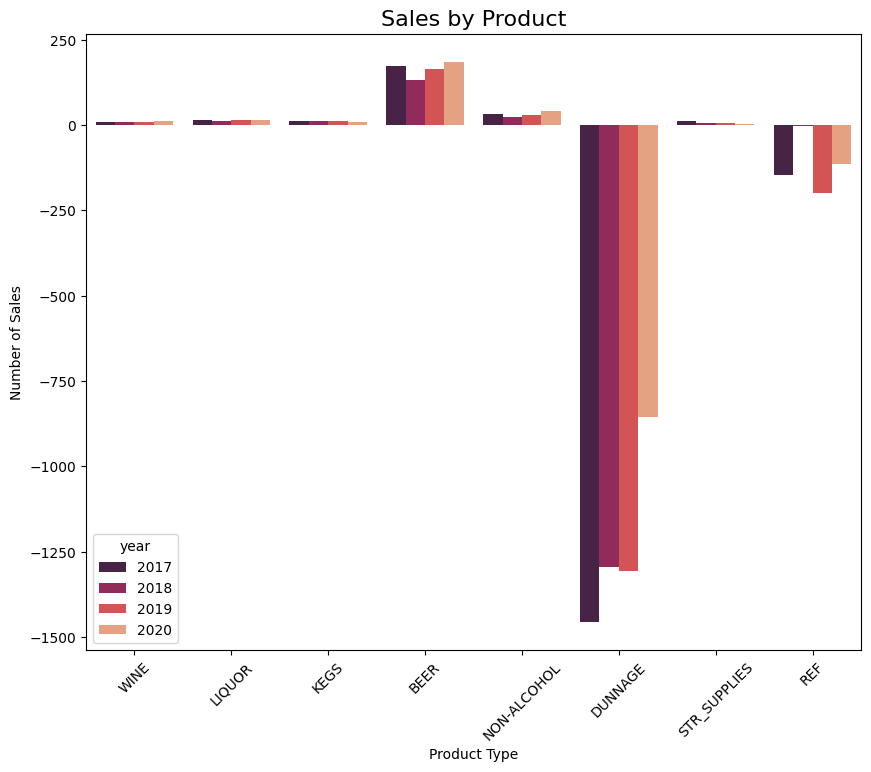

In [32]:
#Set seaborn plotting aesthetics
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x ='item_type', y = 'total_sales', hue = 'year', data = df2, palette = ("rocket"), errorbar = None)
plt.title('Sales by Product', fontsize = 16)
plt.xlabel('Product Type')
plt.ylabel('Number of Sales')
plt.xticks(rotation = 45)

In [33]:
#Remove values that amount to cost, rather than sales
df2 = df2[df2.item_type != 'DUNNAGE']
df2 = df2[df2.item_type != 'REF']
df2

,year,item_type,total_sales
54813,2017,WINE,4.00
51933,2017,WINE,1.00
51932,2017,LIQUOR,14.33
51931,2017,WINE,0.08
51930,2017,LIQUOR,1.52
...,...,...,...
27070,2020,WINE,5.00
27050,2020,WINE,7.00
307660,2020,WINE,1.00
307661,2020,WINE,2.25


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'WINE'),
  Text(1, 0, 'LIQUOR'),
  Text(2, 0, 'KEGS'),
  Text(3, 0, 'BEER'),
  Text(4, 0, 'NON-ALCOHOL'),
  Text(5, 0, 'STR_SUPPLIES')])

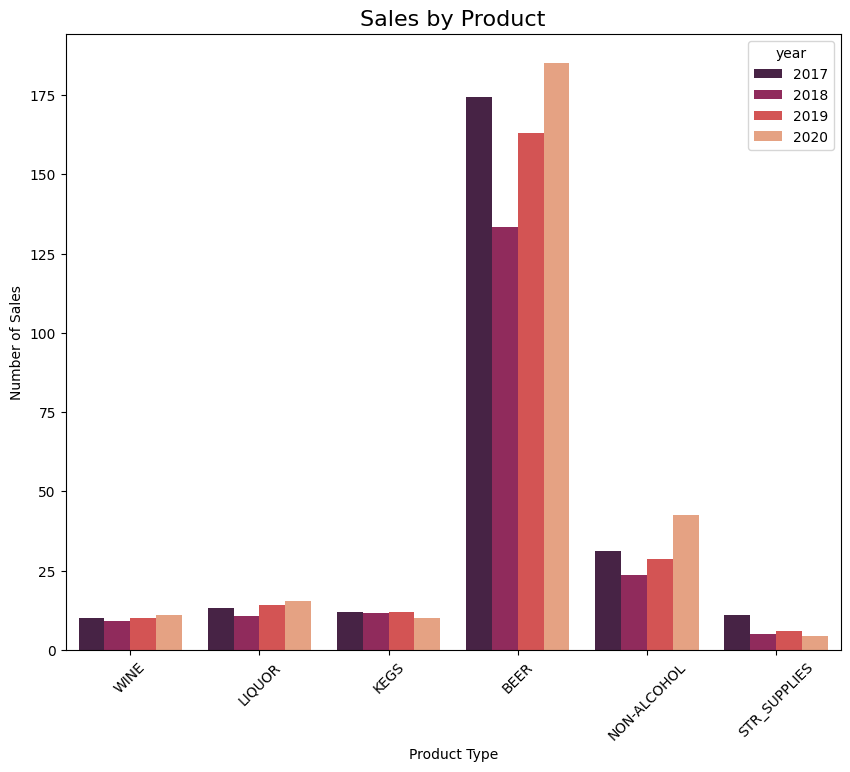

In [34]:
#Plot again, without negative values
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x ='item_type', y = 'total_sales', hue = 'year', data = df2, palette = ("rocket"), errorbar = None)
plt.title('Sales by Product', fontsize = 16)
plt.xlabel('Product Type')
plt.ylabel('Number of Sales')
plt.xticks(rotation = 45)

In [30]:
#Set the dates as the index value
#df.set_index('date', drop = True, inplace = True)
#df.head()

In [35]:
df

,year,month,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,item_type,retail_sales,RETAIL TRANSFERS,warehouse_sales,total_sales,day,date
54813,2017,6,BACCHUS IMPORTERS LTD,429600,PERELADA BLC PESCADOR - 750ML,WINE,0.00,0.0,4.0,4.00,1,2017-06-01
51933,2017,6,REPUBLIC NATIONAL DISTRIBUTING CO,333707,STONESTREET ESTATE A/V CHARD - 750ML,WINE,0.00,0.0,1.0,1.00,1,2017-06-01
51932,2017,6,SOUTHERN GLAZERS WINE AND SPIRITS,333688,CASAMIGOS TEQUILA -ANEJO - 750ML,LIQUOR,9.33,7.0,5.0,14.33,1,2017-06-01
51931,2017,6,THE HESS COLLECTION,333686,GLEN CARLOU GR CLASSIQUE - 750ML,WINE,0.08,1.0,0.0,0.08,1,2017-06-01
51930,2017,6,BACCHUS IMPORTERS LTD,333668,BARR HILL VODKA - 750ML,LIQUOR,1.52,0.0,0.0,1.52,1,2017-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...
27070,2020,9,GRAPES OF SPAIN INC,317500,U MES U FAN CAVA BRUT - 750ML,WINE,0.00,0.0,5.0,5.00,1,2020-09-01
27050,2020,9,THE TRITON COLLECTION INC,317022,STELLAR ORGANICS CAB - 750ML,WINE,0.00,0.0,7.0,7.00,1,2020-09-01
307660,2020,10,PRESTIGE BEVERAGE GROUP OF MD LLC,318272,DELOACH MER - 750ML,WINE,0.00,0.0,1.0,1.00,1,2020-10-01
307661,2020,11,PRESTIGE BEVERAGE GROUP OF MD LLC,318276,BODEGAS BRECA GARN - 750ML,WINE,0.25,0.0,2.0,2.25,1,2020-11-01


In [36]:
#Drop unnecessary columns
df = df[['total_sales', 'date']]
df

,total_sales,date
54813,4.00,2017-06-01
51933,1.00,2017-06-01
51932,14.33,2017-06-01
51931,0.08,2017-06-01
51930,1.52,2017-06-01
...,...,...
27070,5.00,2020-09-01
27050,7.00,2020-09-01
307660,1.00,2020-10-01
307661,2.25,2020-11-01


In [38]:
df = df.groupby('date').sum().round(2)
df

,total_sales
date,
2017-06-01,476748.09
2017-07-01,409478.58
2017-08-01,469298.47
2017-09-01,395893.13
2017-10-01,392951.87
2017-11-01,437621.85
2017-12-01,438591.71
2018-01-01,330309.44
2018-02-01,342928.65


In [ ]:
df['sales_value'] = df['total_sales'].cumsum(axis = None).round(2)
df

In [ ]:
#Create visualization for DataFrame
index = df.index
fig, ax = plt.subplots(figsize = (10,8))

plt.xlabel('Date')
plt.ylabel('# of Sales')
plt.title('Alcoholic Sales Data for Montgomery County, MD')
plt.plot(index, df.sales_value, color = 'purple')
plt.show()

In [ ]:
#Plot again, without negative values
fig, ax = plt.subplots(figsize = (10, 8))
index = df.index

sns.lineplot(x ='item_type', y = 'total_sales', hue = 'year', data = df, palette = ("viridis"), errorbar = None)
plt.title('Sales by Product', fontsize = 16)
plt.xlabel('Product Type')
plt.ylabel('Number of Sales')
plt.xticks(rotation = 45)

In [ ]:
#Create a third DataFrame for this visualization
df3 = df[df.item_type != 'REF']
df3 = df[df.item_type != 'DUNNAGE']


In [ ]:
#Plot again, without negative values
fig, ax = plt.subplots(figsize = (10, 8))

sns.lineplot(x ='item_type', y = 'total_sales', hue = 'year', data = df3, palette = ("viridis"), errorbar = None)
plt.title('Sales by Product', fontsize = 16)
plt.xlabel('Product Type')
plt.ylabel('Number of Sales')
plt.xticks(rotation = 45)

In [ ]:
#Use ADF to assess whether dataset is stationary or non-stationary 
df_test = ts.adfuller(df['total_sales'], autolag = 'AIC')
df_op = pd.Series(df_test[0:4], index = ['ADF Statistic', 'p-Value', 'Lags', 'Observations'])
for key, value in df_test[4].items():
    df_op['Critical Value (%s)'%key] = value
df_op

In [ ]:
print(df2.info())

In [ ]:
df2.head()

In [ ]:
#Transform dataset to stationary by using differencing (subtracting each point from the previous value).
df_stationary = df2.diff(periods = 1, axis = 0).dropna()
print(df_stationary.info())
print(df_stationary.shape)

In [ ]:
index2 = pd.Series(range(df_stationary.shape[0]))
fig, ax = plt.subplots(figsize = (10,8))

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Medical Data')
plt.plot(index2, df_stationary.Revenue, color = 'purple')
plt.show()

In [ ]:
#Use ADF to reassess whether updated dataset is stationary or non-stationary 
df_test2 = ts.adfuller(df_stationary['Revenue'], autolag = 'AIC')
df_op2 = pd.Series(df_test2[0:4], index = ['ADF Statistic', 'p-Value', 'Lags', 'Observations'])
for key, value in df_test2[4].items():
    df_op2['Critical Value (%s)'%key] = value
df_op2

In [ ]:
#Create Training and Test, keeping the recommended 4:1 ratio
test_size = int(.20 * df_stationary.shape[0])
train, test = train_test_split(df_stationary, test_size = test_size, shuffle = False, random_state = 22)

In [ ]:
acf = acf((train['Revenue'].values))
acf_df = pd.DataFrame([acf]).T
acf_df.columns = ['ACF']

In [ ]:
#ACF Visualization
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(acf_df.ACF, 'purple')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Autocorrelation (ACF)')
plt.show()

In [ ]:
pacf = pacf((train['Revenue'].values))
pacf_df = pd.DataFrame([pacf]).T
pacf_df.columns = ['PACF']

In [ ]:
#PACF Visualization
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(pacf_df.PACF, 'purple')
ax.hlines(y = 0.05, xmin = 0, xmax = len(pacf), lw = 1, linestyles = '--', color = 'black', label = 'P(0.05)')
ax.legend()
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Partial Autocorrelation (ACF)')
plt.show()

In [ ]:
df2.to_csv('E:/HDD Documents/HDD Documents/School/WGU/d213_advanced_data_analytics/Task 1/data/task_1_df2_cleaned.csv')

In [ ]:
df_stationary.to_csv('E:/HDD Documents/HDD Documents/School/WGU/d213_advanced_data_analytics/Task 1/data/task_1_df_stationary.csv')

In [ ]:
#Use seasonal_decompose to plot decomposition values
decomposition = seasonal_decompose(df2['Revenue'].values, model = 'additive', period = 1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(df2['Revenue'].values, label = 'Original', color = 'mediumorchid')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend', color = 'deepskyblue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality', color = 'mediumaquamarine')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label = 'Residuals', color = 'wheat')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
plt.psd(df_stationary['Revenue'])
plt.title('Spectral Density')
plt.show()

In [ ]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [ ]:
stepwise_fit = auto_arima(df2['Revenue'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

In [ ]:
model = ARIMA(df2['Revenue'],order = (1,1,0))
model = model.fit()
model.summary()

In [ ]:
print(df2.shape)
train = df2.iloc[:-30]
test = df2.iloc[-30:]
print(train.shape, test.shape)

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start = start, end = end,typ = 'levels').rename('Predictions')
print(pred)

pred.index = df2.index[start:end + 1]

In [ ]:
pred.plot(legend = True)
test['Revenue'].plot(legend = True)
plt.xlabel('Dates: 12-02-2016 - 12-31-2016')
plt.ylabel('Revenue in Millions')
plt.title('Prediction Compared to Last 30 Days')
plt.show()

In [ ]:
test['Revenue'].mean()

In [ ]:
rmse = sqrt(mean_squared_error(pred, test['Revenue']))
rmse

In [ ]:
model2 = ARIMA(df2['Revenue'], order = (1, 1, 0))
model2 = model2.fit()
df2.tail()

In [ ]:
index_future_dates = pd.date_range(start='2016-12-31', end = '2017-01-31')
print(index_future_dates)
pred = model.predict(start = len(train), end = len(train) + 31, typ ='levels').rename('30 Day Revenue Predictions')
pred.index = index_future_dates
pred

In [ ]:
pred.plot(legend = True)
plt.xlabel('Dates: 01-01-2017 - 01-31-2017')
plt.ylabel('Revenue in Millions')
plt.title('Model Fitted to Training Data Only')
plt.show()